In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, \
show_summaries, get_base_predictions, get_multi_base_predictions
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_ensemble

In [2]:
cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

In [3]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    results = IO(data_dir + 'results/results.pkl').read_pickle()
    is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
    datanames = IO(data_dir + 'results/datanames.pkl').read_pickle()

    ys_base_train, ys_base_test, ys_base_cv, weights = get_base_predictions(results, is_successful, datanames, thres=0.05)
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()
    data_split = [ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights]
    IO(data_dir + '061_data_split.pkl').to_pickle(data_split)
    
    results = [IO(data_dir + 'results/results.pkl').read_pickle(), IO(data_dir + 'results05/results.pkl').read_pickle()]
    is_successful = [IO(data_dir + 'results/is_successful.pkl').read_pickle(), \
                     IO(data_dir + 'results05/is_successful.pkl').read_pickle()]
    datanames = [IO(data_dir + 'results/datanames.pkl').read_pickle(), \
                 IO(data_dir + 'results05/datanames.pkl').read_pickle()]
    ys_base_train, ys_base_test, ys_base_cv, weights = \
    get_multi_base_predictions(results, is_successful, datanames, thres=0.05)
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()
    data_split = [ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights]
    IO(data_dir + '062_data_split.pkl').to_pickle(data_split)

Champaign...
Cleveland...
Pittsburgh...
Toronto...
Las_Vegas...
Full...
Wall time: 1min 59s


In [4]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    models = [RS_ensemble(estimator=None), RS_ensemble(estimator=RidgeCV()), \
              RS_ensemble(estimator=RandomForestRegressor(n_estimators=50, max_depth=3)), \
              RS_ensemble(estimator=None), RS_ensemble(estimator=RidgeCV()), \
              RS_ensemble(estimator=RandomForestRegressor(n_estimators=50, max_depth=3))]
    switch = [False, False, False, True, False, False]
    model_names = ['Ensemble1 (weighted average)', 'Ensemble1 (Ridge regression)', 'Ensemble1 (random forest)', \
                   'Ensemble2 (weighted average)', 'Ensemble2 (Ridge regression)', 'Ensemble2 (random forest)']
    datanames = [data_dir + 'results06/' + str(i) + '.pkl' for i in range(len(models))]
    
    IO(data_dir + 'results06/models.pkl').to_pickle(models)
    IO(data_dir + 'results06/model_names.pkl').to_pickle(model_names)
    IO(data_dir + 'results06/switch.pkl').to_pickle(switch)
    IO(data_dir + 'results06/datanames.pkl').to_pickle(datanames)

Champaign...
Cleveland...
Pittsburgh...
Toronto...
Las_Vegas...
Full...
Wall time: 37 ms


In [5]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    
    is_successful = []
    
    datanames = IO(data_dir + 'results06/datanames.pkl').read_pickle()
    models = IO(data_dir + 'results06/models.pkl').read_pickle()
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    switch = IO(data_dir + 'results06/switch.pkl').read_pickle()
    
    ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
    IO(data_dir + '061_data_split.pkl').read_pickle()
    
    for i, model in enumerate(models):
        if switch[i]:
            ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
            IO(data_dir + '062_data_split.pkl').read_pickle()
        try:
            print(model_names[i] + '...')
            model.fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
            print(model_names[i] + 'fitting successful.')
            IO(datanames[i]).to_pickle(model)
            print('Saving to pickle successful.')
            del model
            is_successful.append(True)
            print()
        except:
            traceback.print_exc()
            print('Failed.')
            is_successful.append(False)
            print()
            
    IO(data_dir + 'results06/is_successful.pkl').to_pickle(is_successful)

Champaign...
Ensemble1 (weighted average)...
Ensemble1 (weighted average)fitting successful.
Saving to pickle successful.

Ensemble1 (Ridge regression)...
Ensemble1 (Ridge regression)fitting successful.
Saving to pickle successful.

Ensemble1 (random forest)...
Ensemble1 (random forest)fitting successful.
Saving to pickle successful.

Ensemble2 (weighted average)...
Ensemble2 (weighted average)fitting successful.
Saving to pickle successful.

Ensemble2 (Ridge regression)...
Ensemble2 (Ridge regression)fitting successful.
Saving to pickle successful.

Ensemble2 (random forest)...
Ensemble2 (random forest)fitting successful.
Saving to pickle successful.

Cleveland...
Ensemble1 (weighted average)...
Ensemble1 (weighted average)fitting successful.
Saving to pickle successful.

Ensemble1 (Ridge regression)...
Ensemble1 (Ridge regression)fitting successful.
Saving to pickle successful.

Ensemble1 (random forest)...
Ensemble1 (random forest)fitting successful.
Saving to pickle successful.

En

In [6]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    
    datanames = IO(data_dir + 'results06/datanames.pkl').read_pickle()
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    switch = IO(data_dir + 'results06/switch.pkl').read_pickle()
    ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
    IO(data_dir + '061_data_split.pkl').read_pickle()
    
    results = []
    for i in range(len(is_successful)):
        print(model_names[i] + '...')
        if switch[i]:
            ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
            IO(data_dir + '062_data_split.pkl').read_pickle()
        if not is_successful[i]:
            results.append(None)
        else:
            model = IO(datanames[i]).read_pickle()
            results.append(get_results(model, X_train=ys_base_train, y_train=y_train, X_test=ys_base_test, y_test=y_test, \
                                       X_cv=ys_base_cv, y_cv=y_cv))
            del model
        
    print('Done.')
    IO(data_dir + 'results06/results.pkl').to_pickle(results)
    print()

Champaign...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Cleveland...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Pittsburgh...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Toronto...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Las_Vegas...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensembl

In [7]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    results = IO(data_dir + 'results06/results.pkl').read_pickle()
    is_successful = IO(data_dir + 'results06/is_successful.pkl').read_pickle()
    sizes = IO(data_dir + 'sizes.pkl').read_pickle()

    display(Markdown('## {} <sup>({} reviews, {} restaurants, {} users)</sup>'.\
                     format(city, sizes[0], sizes[1], sizes[2])))
    display(Markdown('**Ensemble**'))
    show_summaries(model_names, results, is_successful)
    display(Markdown('<sup>(Ensemble1 represents the ensemble of collaborative filtering models; \
    Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>'))

Champaign...


## Champaign <sup>(20571 reviews, 878 restaurants, 8451 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.000,0.8115,1.3059,0.6788,0.1897
Ensemble1 (Ridge regression),0.009,1.1826,1.3031,0.3178,0.1931
Ensemble1 (random forest),0.223,0.9920,1.3017,0.5200,0.1949
Ensemble2 (weighted average),0.000,0.8826,1.1566,0.6200,0.3643
Ensemble2 (Ridge regression),0.004,1.2147,1.0813,0.2803,0.4444
Ensemble2 (random forest),0.272,1.0645,1.0850,0.4473,0.4406


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Cleveland...


## Cleveland <sup>(75932 reviews, 2500 restaurants, 30131 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.7191,1.2072,0.7140,0.1971
Ensemble1 (Ridge regression),0.0050,0.8871,1.2043,0.5646,0.2011
Ensemble1 (random forest),0.7210,0.8811,1.2063,0.5706,0.1984
Ensemble2 (weighted average),0.0000,0.8028,1.0899,0.6435,0.3456
Ensemble2 (Ridge regression),0.0060,1.0329,1.0143,0.4099,0.4333
Ensemble2 (random forest),0.9471,0.9987,1.0181,0.4483,0.4290


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Pittsburgh...


## Pittsburgh <sup>(143682 reviews, 4745 restaurants, 46179 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.7684,1.1900,0.6645,0.1951
Ensemble1 (Ridge regression),0.0130,0.8872,1.1872,0.5527,0.1988
Ensemble1 (random forest),1.3041,0.8644,1.1891,0.5754,0.1962
Ensemble2 (weighted average),0.0000,0.8410,1.0594,0.5981,0.3620
Ensemble2 (Ridge regression),0.0150,0.9928,0.9881,0.4399,0.4450
Ensemble2 (random forest),1.7021,0.9995,0.9929,0.4323,0.4396


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Toronto...


## Toronto <sup>(331407 reviews, 12118 restaurants, 77506 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.7721,1.1648,0.6440,0.1856
Ensemble1 (Ridge regression),0.0290,0.9701,1.1617,0.4380,0.1898
Ensemble1 (random forest),3.2702,0.9747,1.1650,0.4327,0.1853
Ensemble2 (weighted average),0.0000,0.8419,1.0529,0.5767,0.3346
Ensemble2 (Ridge regression),0.0360,1.0278,0.9876,0.3692,0.4145
Ensemble2 (random forest),4.1732,0.9946,0.9957,0.4093,0.4048


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Las_Vegas...


## Las_Vegas <sup>(1280896 reviews, 20434 restaurants, 429363 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.7228,1.2640,0.7476,0.2280
Ensemble1 (Ridge regression),0.1190,0.9909,1.2605,0.5257,0.2323
Ensemble1 (random forest),13.3968,1.0422,1.2631,0.4753,0.2290
Ensemble2 (weighted average),0.0000,0.8461,1.1686,0.6542,0.3402
Ensemble2 (Ridge regression),0.1470,1.1212,1.1013,0.3928,0.4139
Ensemble2 (random forest),16.1289,1.1063,1.1084,0.4088,0.4064


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Full...


## Full <sup>(4166778 reviews, 131025 restaurants, 1117891 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.7803,1.2557,0.6990,0.2214
Ensemble1 (Ridge regression),0.4240,1.0004,1.2523,0.5051,0.2256
Ensemble1 (random forest),56.5742,1.0303,1.2581,0.4751,0.2184
Ensemble2 (weighted average),0.0000,0.8688,1.1421,0.6268,0.3558
Ensemble2 (Ridge regression),0.5450,1.1033,1.0617,0.3980,0.4434
Ensemble2 (random forest),68.1969,1.0687,1.0702,0.4352,0.4344


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Wall time: 464 ms


Champaign...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8115.  
            RMSE on test set: 1.3059.  
            $R^2$ on training set: 0.6788.   
            $R^2$ on test set: 0.1897.  
            Classification accuracy on training set: 0.4174.  
            Classification accuracy on test set: 0.2529.
            

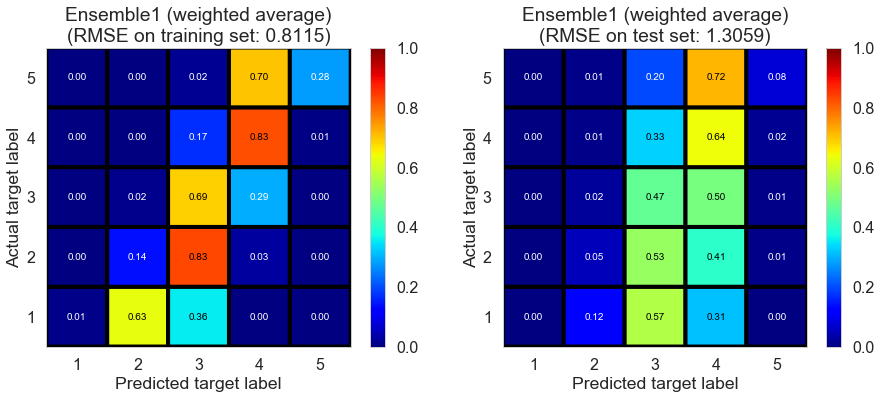

### Ensemble1 (Ridge regression)

Fitting time: 0.0090 s.  
            RMSE on training set: 1.1826.  
            RMSE on test set: 1.3031.  
            $R^2$ on training set: 0.3178.   
            $R^2$ on test set: 0.1931.  
            Classification accuracy on training set: 0.2656.  
            Classification accuracy on test set: 0.2574.
            

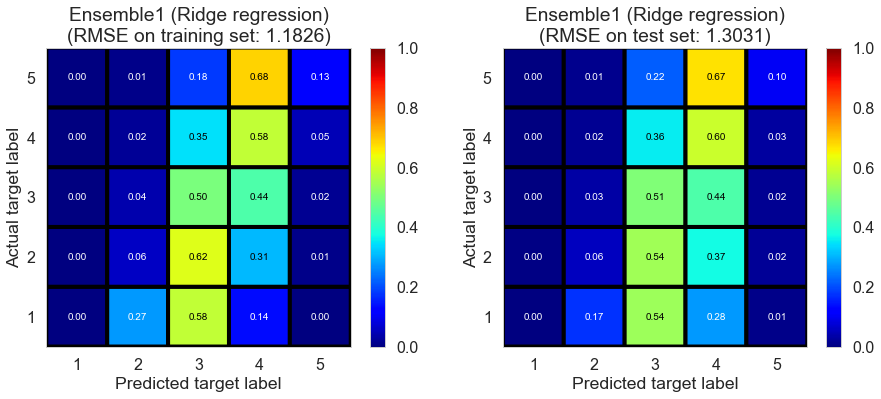

### Ensemble1 (random forest)

Fitting time: 0.2230 s.  
            RMSE on training set: 0.9920.  
            RMSE on test set: 1.3017.  
            $R^2$ on training set: 0.5200.   
            $R^2$ on test set: 0.1949.  
            Classification accuracy on training set: 0.3534.  
            Classification accuracy on test set: 0.2627.
            

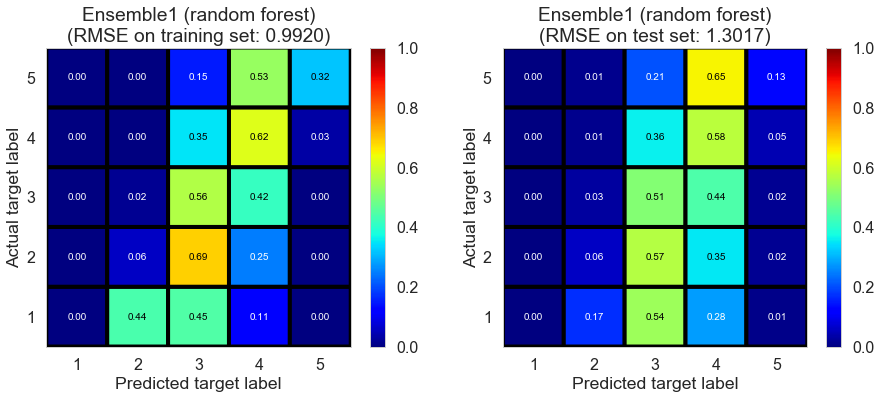

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8826.  
            RMSE on test set: 1.1566.  
            $R^2$ on training set: 0.6200.   
            $R^2$ on test set: 0.3643.  
            Classification accuracy on training set: 0.4029.  
            Classification accuracy on test set: 0.3064.
            

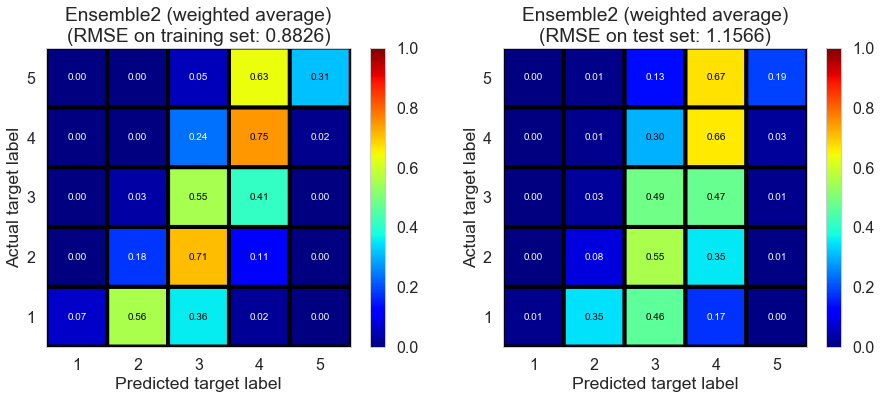

### Ensemble2 (Ridge regression)

Fitting time: 0.0040 s.  
            RMSE on training set: 1.2147.  
            RMSE on test set: 1.0813.  
            $R^2$ on training set: 0.2803.   
            $R^2$ on test set: 0.4444.  
            Classification accuracy on training set: 0.3512.  
            Classification accuracy on test set: 0.4062.
            

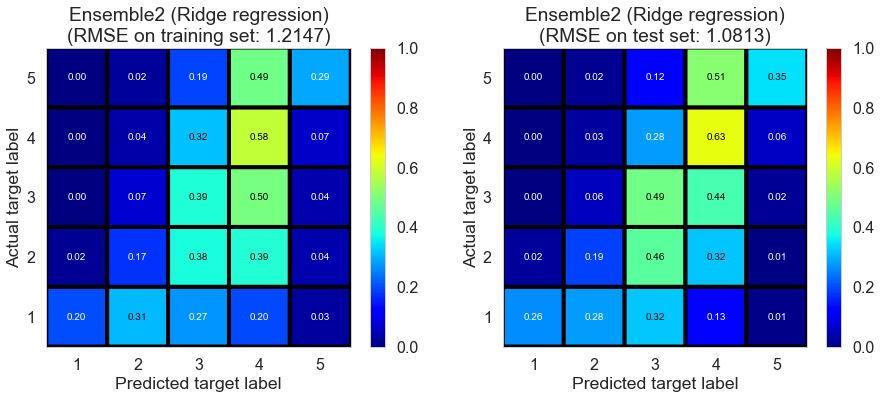

### Ensemble2 (random forest)

Fitting time: 0.2720 s.  
            RMSE on training set: 1.0645.  
            RMSE on test set: 1.0850.  
            $R^2$ on training set: 0.4473.   
            $R^2$ on test set: 0.4406.  
            Classification accuracy on training set: 0.4040.  
            Classification accuracy on test set: 0.4002.
            

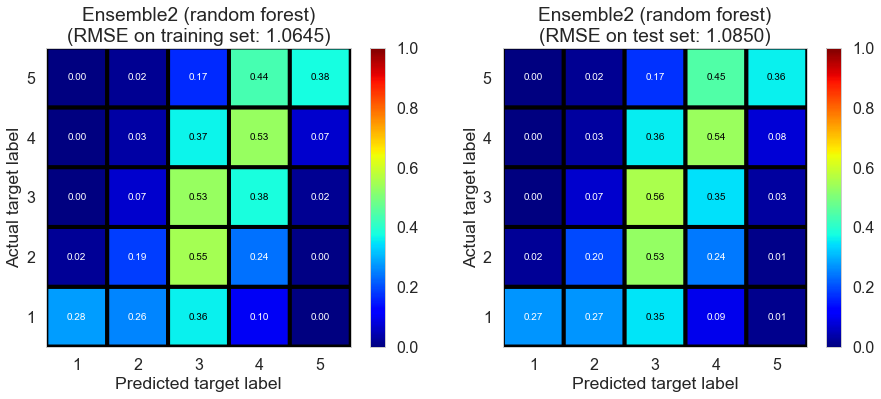


Cleveland...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.7191.  
            RMSE on test set: 1.2072.  
            $R^2$ on training set: 0.7140.   
            $R^2$ on test set: 0.1971.  
            Classification accuracy on training set: 0.5267.  
            Classification accuracy on test set: 0.3066.
            

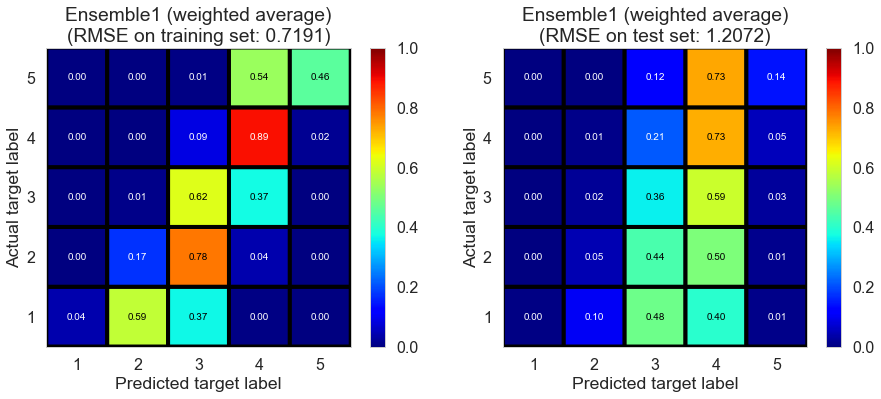

### Ensemble1 (Ridge regression)

Fitting time: 0.0050 s.  
            RMSE on training set: 0.8871.  
            RMSE on test set: 1.2043.  
            $R^2$ on training set: 0.5646.   
            $R^2$ on test set: 0.2011.  
            Classification accuracy on training set: 0.4046.  
            Classification accuracy on test set: 0.3124.
            

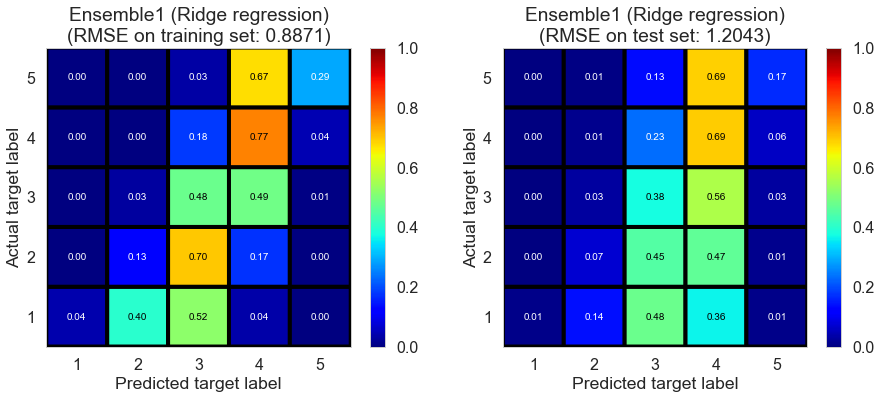

### Ensemble1 (random forest)

Fitting time: 0.7210 s.  
            RMSE on training set: 0.8811.  
            RMSE on test set: 1.2063.  
            $R^2$ on training set: 0.5706.   
            $R^2$ on test set: 0.1984.  
            Classification accuracy on training set: 0.3519.  
            Classification accuracy on test set: 0.2978.
            

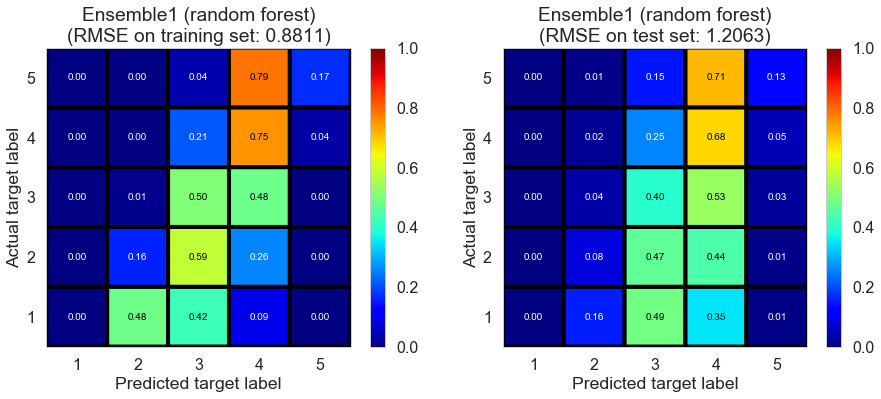

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8028.  
            RMSE on test set: 1.0899.  
            $R^2$ on training set: 0.6435.   
            $R^2$ on test set: 0.3456.  
            Classification accuracy on training set: 0.4711.  
            Classification accuracy on test set: 0.3435.
            

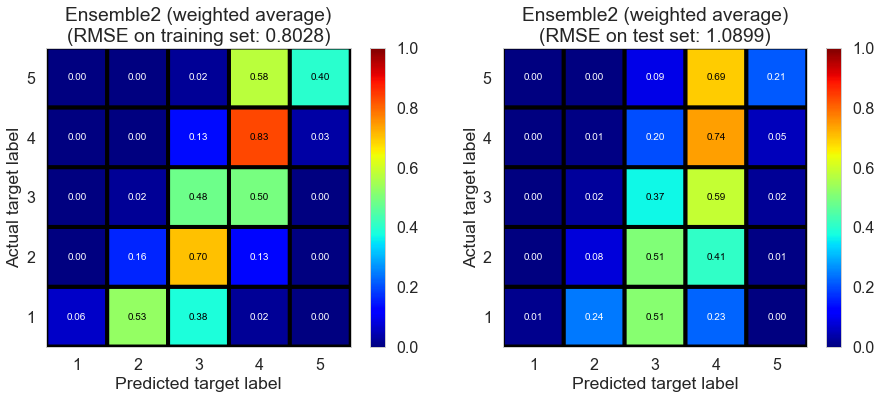

### Ensemble2 (Ridge regression)

Fitting time: 0.0060 s.  
            RMSE on training set: 1.0329.  
            RMSE on test set: 1.0143.  
            $R^2$ on training set: 0.4099.   
            $R^2$ on test set: 0.4333.  
            Classification accuracy on training set: 0.4248.  
            Classification accuracy on test set: 0.4309.
            

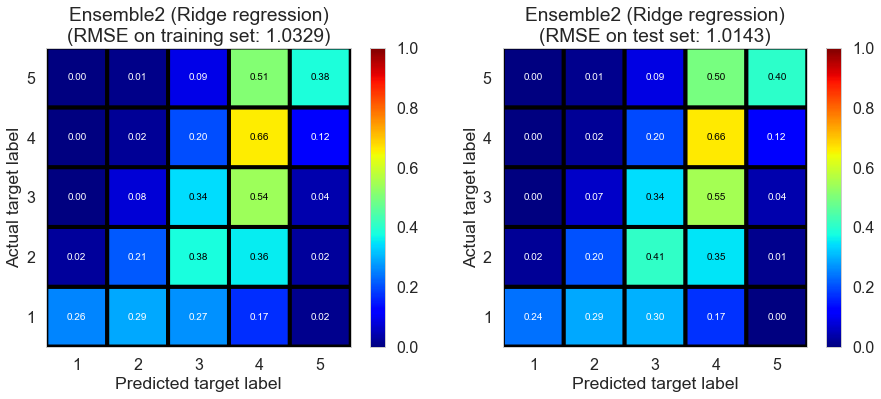

### Ensemble2 (random forest)

Fitting time: 0.9471 s.  
            RMSE on training set: 0.9987.  
            RMSE on test set: 1.0181.  
            $R^2$ on training set: 0.4483.   
            $R^2$ on test set: 0.4290.  
            Classification accuracy on training set: 0.4293.  
            Classification accuracy on test set: 0.4211.
            

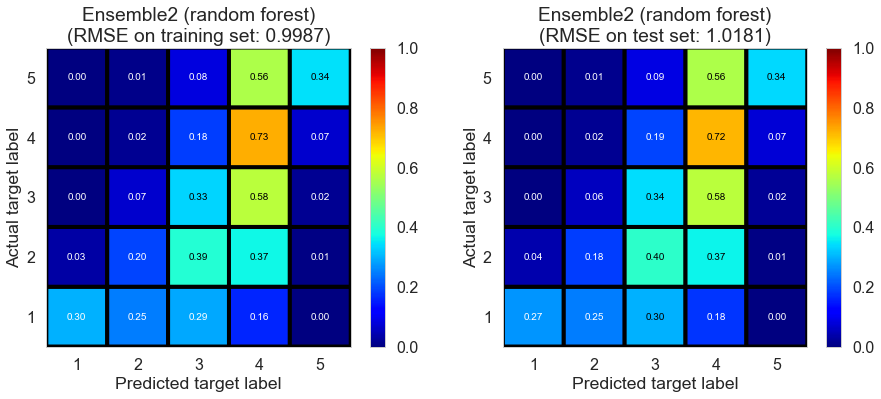


Pittsburgh...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.7684.  
            RMSE on test set: 1.1900.  
            $R^2$ on training set: 0.6645.   
            $R^2$ on test set: 0.1951.  
            Classification accuracy on training set: 0.4852.  
            Classification accuracy on test set: 0.3054.
            

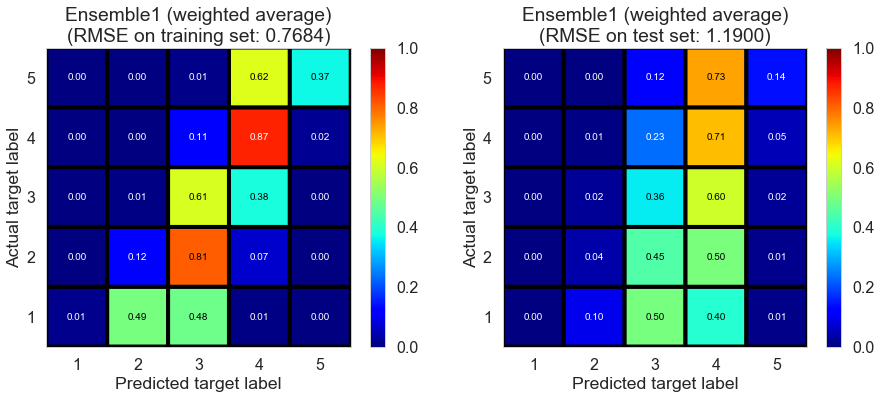

### Ensemble1 (Ridge regression)

Fitting time: 0.0130 s.  
            RMSE on training set: 0.8872.  
            RMSE on test set: 1.1872.  
            $R^2$ on training set: 0.5527.   
            $R^2$ on test set: 0.1988.  
            Classification accuracy on training set: 0.4096.  
            Classification accuracy on test set: 0.3107.
            

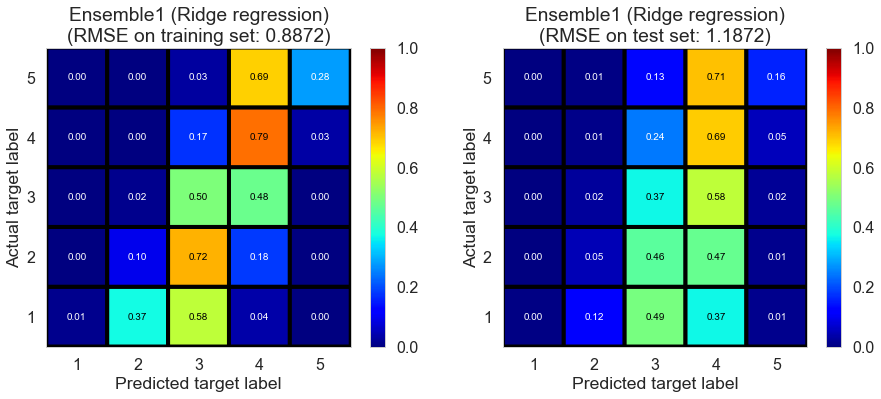

### Ensemble1 (random forest)

Fitting time: 1.3041 s.  
            RMSE on training set: 0.8644.  
            RMSE on test set: 1.1891.  
            $R^2$ on training set: 0.5754.   
            $R^2$ on test set: 0.1962.  
            Classification accuracy on training set: 0.4546.  
            Classification accuracy on test set: 0.3197.
            

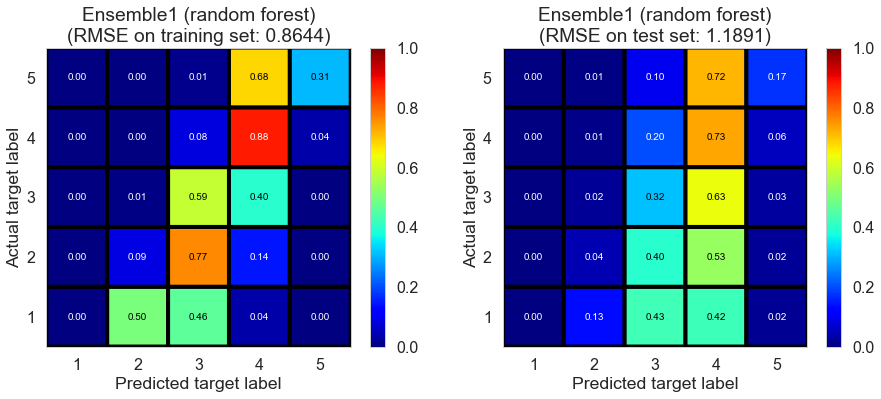

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8410.  
            RMSE on test set: 1.0594.  
            $R^2$ on training set: 0.5981.   
            $R^2$ on test set: 0.3620.  
            Classification accuracy on training set: 0.4579.  
            Classification accuracy on test set: 0.3543.
            

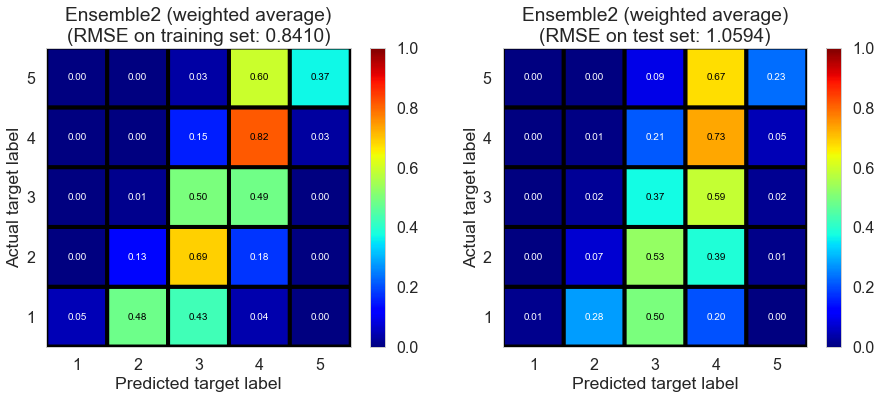

### Ensemble2 (Ridge regression)

Fitting time: 0.0150 s.  
            RMSE on training set: 0.9928.  
            RMSE on test set: 0.9881.  
            $R^2$ on training set: 0.4399.   
            $R^2$ on test set: 0.4450.  
            Classification accuracy on training set: 0.4448.  
            Classification accuracy on test set: 0.4445.
            

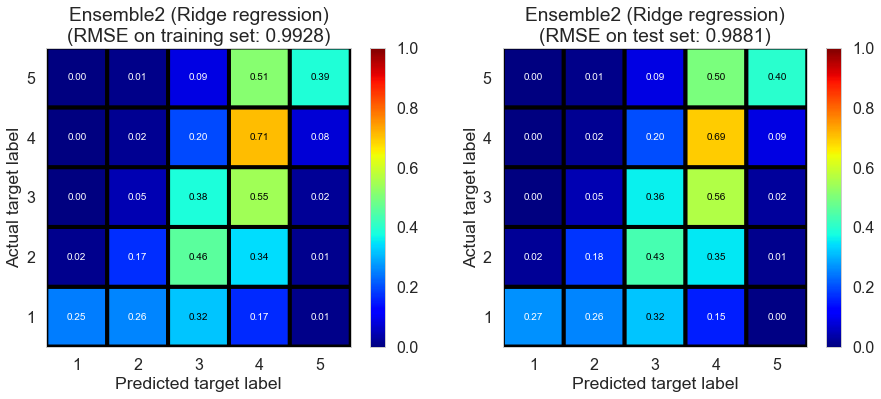

### Ensemble2 (random forest)

Fitting time: 1.7021 s.  
            RMSE on training set: 0.9995.  
            RMSE on test set: 0.9929.  
            $R^2$ on training set: 0.4323.   
            $R^2$ on test set: 0.4396.  
            Classification accuracy on training set: 0.4436.  
            Classification accuracy on test set: 0.4457.
            

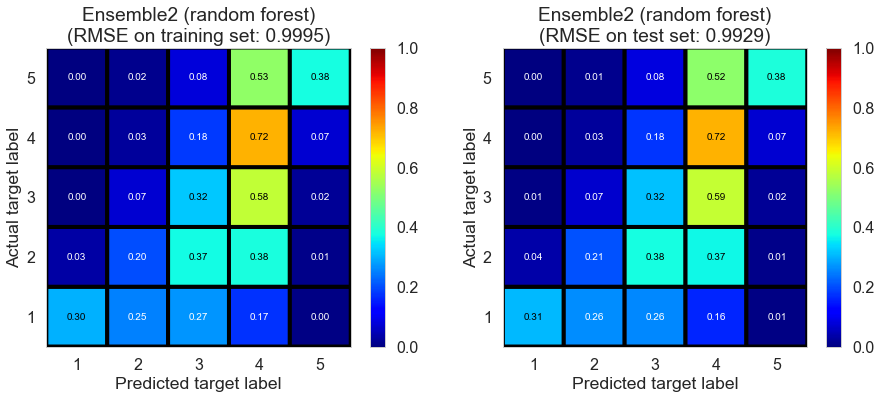


Toronto...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.7721.  
            RMSE on test set: 1.1648.  
            $R^2$ on training set: 0.6440.   
            $R^2$ on test set: 0.1856.  
            Classification accuracy on training set: 0.4753.  
            Classification accuracy on test set: 0.3243.
            

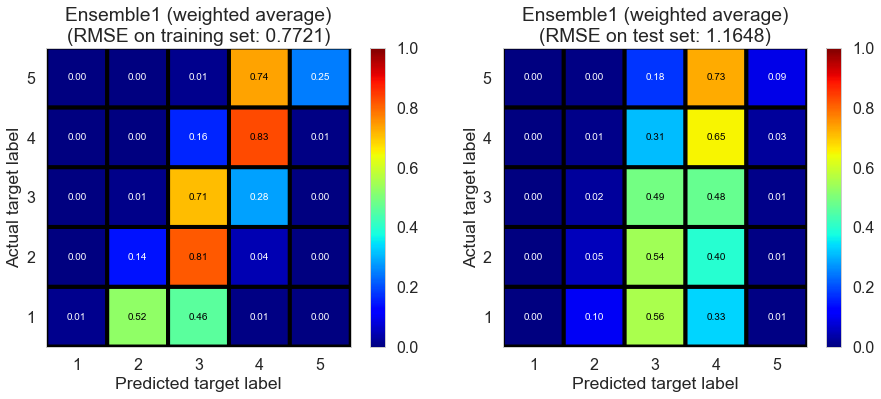

### Ensemble1 (Ridge regression)

Fitting time: 0.0290 s.  
            RMSE on training set: 0.9701.  
            RMSE on test set: 1.1617.  
            $R^2$ on training set: 0.4380.   
            $R^2$ on test set: 0.1898.  
            Classification accuracy on training set: 0.3722.  
            Classification accuracy on test set: 0.3278.
            

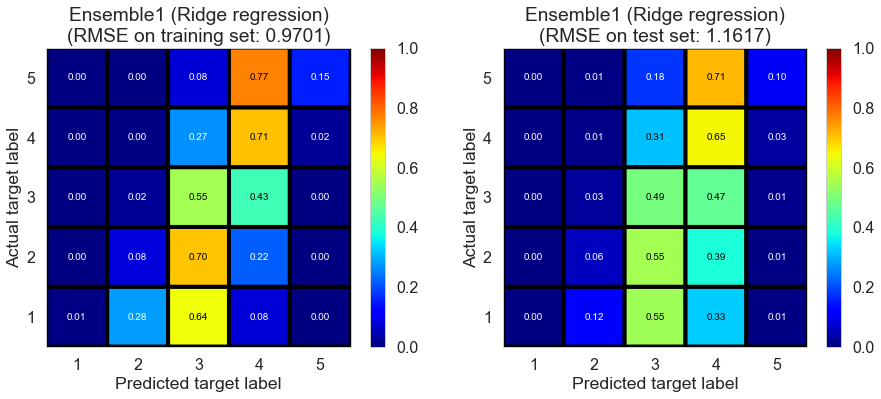

### Ensemble1 (random forest)

Fitting time: 3.2702 s.  
            RMSE on training set: 0.9747.  
            RMSE on test set: 1.1650.  
            $R^2$ on training set: 0.4327.   
            $R^2$ on test set: 0.1853.  
            Classification accuracy on training set: 0.3149.  
            Classification accuracy on test set: 0.3025.
            

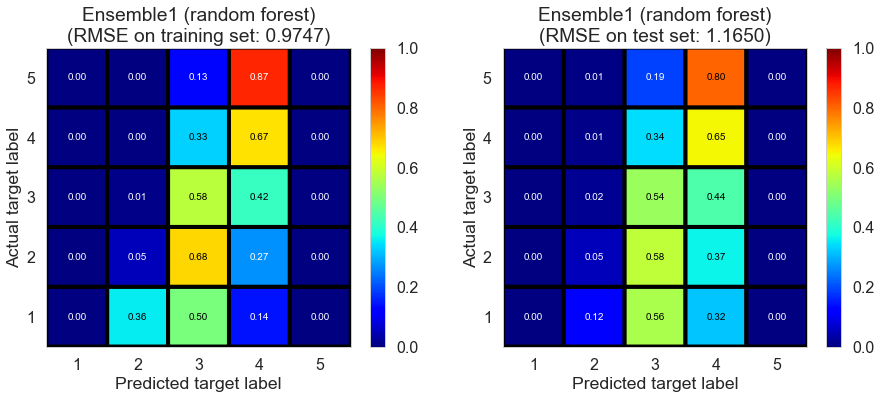

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8419.  
            RMSE on test set: 1.0529.  
            $R^2$ on training set: 0.5767.   
            $R^2$ on test set: 0.3346.  
            Classification accuracy on training set: 0.4469.  
            Classification accuracy on test set: 0.3609.
            

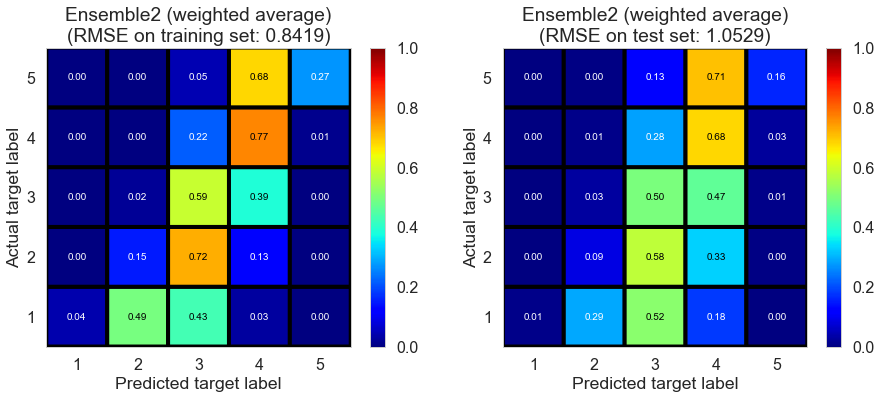

### Ensemble2 (Ridge regression)

Fitting time: 0.0360 s.  
            RMSE on training set: 1.0278.  
            RMSE on test set: 0.9876.  
            $R^2$ on training set: 0.3692.   
            $R^2$ on test set: 0.4145.  
            Classification accuracy on training set: 0.4119.  
            Classification accuracy on test set: 0.4294.
            

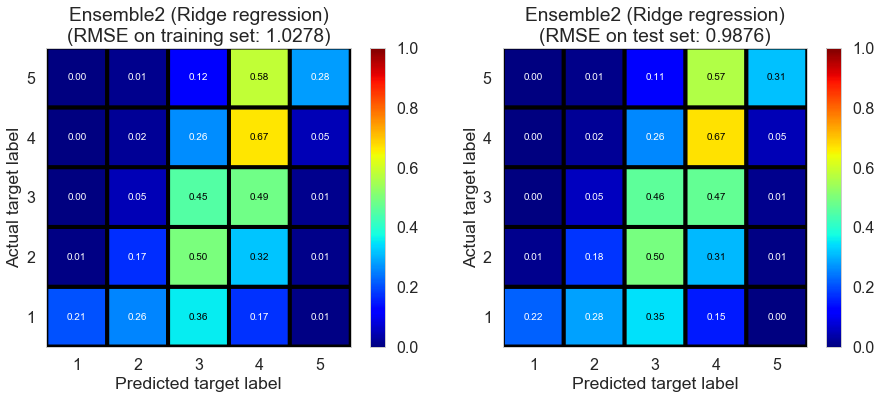

### Ensemble2 (random forest)

Fitting time: 4.1732 s.  
            RMSE on training set: 0.9946.  
            RMSE on test set: 0.9957.  
            $R^2$ on training set: 0.4093.   
            $R^2$ on test set: 0.4048.  
            Classification accuracy on training set: 0.4274.  
            Classification accuracy on test set: 0.4295.
            

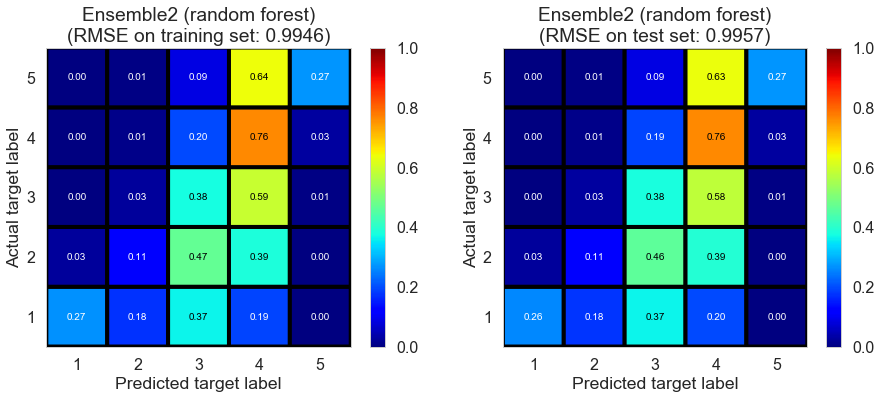


Las_Vegas...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.7228.  
            RMSE on test set: 1.2640.  
            $R^2$ on training set: 0.7476.   
            $R^2$ on test set: 0.2280.  
            Classification accuracy on training set: 0.5292.  
            Classification accuracy on test set: 0.2888.
            

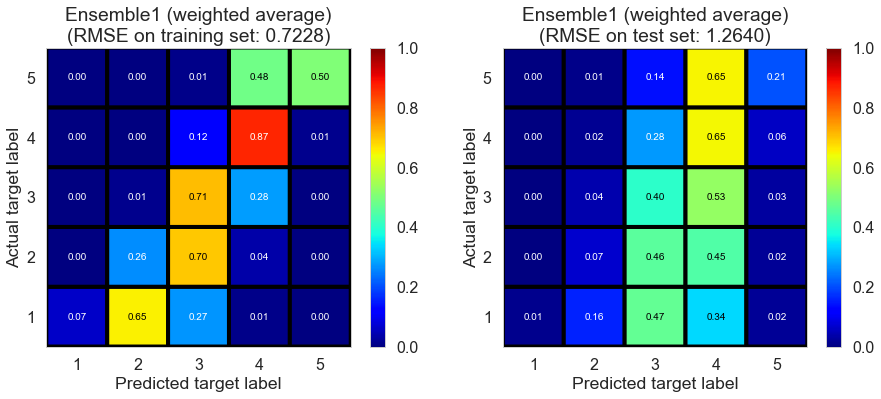

### Ensemble1 (Ridge regression)

Fitting time: 0.1190 s.  
            RMSE on training set: 0.9909.  
            RMSE on test set: 1.2605.  
            $R^2$ on training set: 0.5257.   
            $R^2$ on test set: 0.2323.  
            Classification accuracy on training set: 0.3789.  
            Classification accuracy on test set: 0.2981.
            

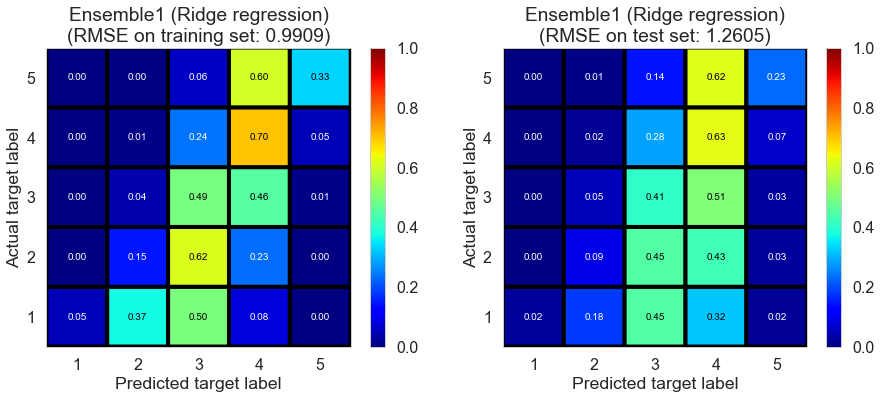

### Ensemble1 (random forest)

Fitting time: 13.3968 s.  
            RMSE on training set: 1.0422.  
            RMSE on test set: 1.2631.  
            $R^2$ on training set: 0.4753.   
            $R^2$ on test set: 0.2290.  
            Classification accuracy on training set: 0.3348.  
            Classification accuracy on test set: 0.2789.
            

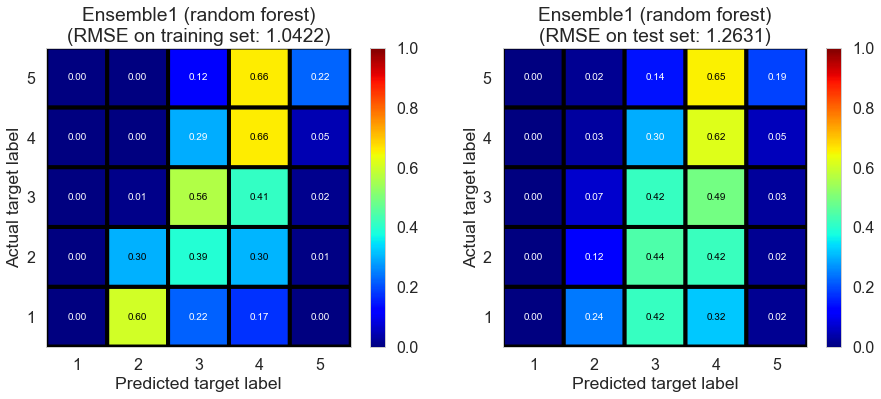

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8461.  
            RMSE on test set: 1.1686.  
            $R^2$ on training set: 0.6542.   
            $R^2$ on test set: 0.3402.  
            Classification accuracy on training set: 0.4561.  
            Classification accuracy on test set: 0.3242.
            

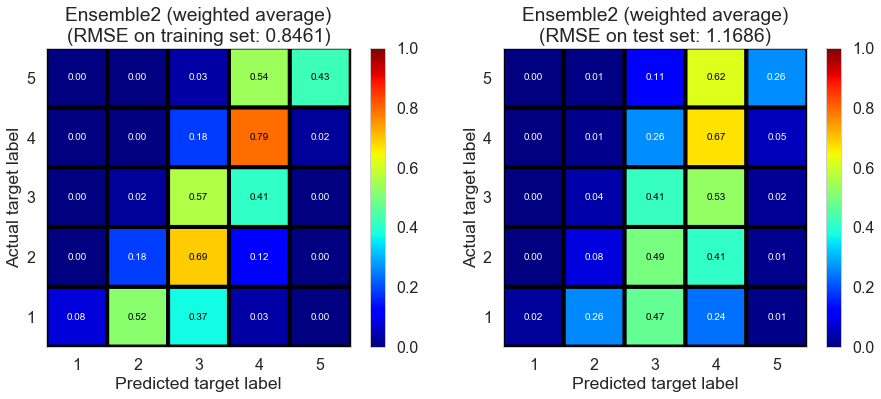

### Ensemble2 (Ridge regression)

Fitting time: 0.1470 s.  
            RMSE on training set: 1.1212.  
            RMSE on test set: 1.1013.  
            $R^2$ on training set: 0.3928.   
            $R^2$ on test set: 0.4139.  
            Classification accuracy on training set: 0.4067.  
            Classification accuracy on test set: 0.4143.
            

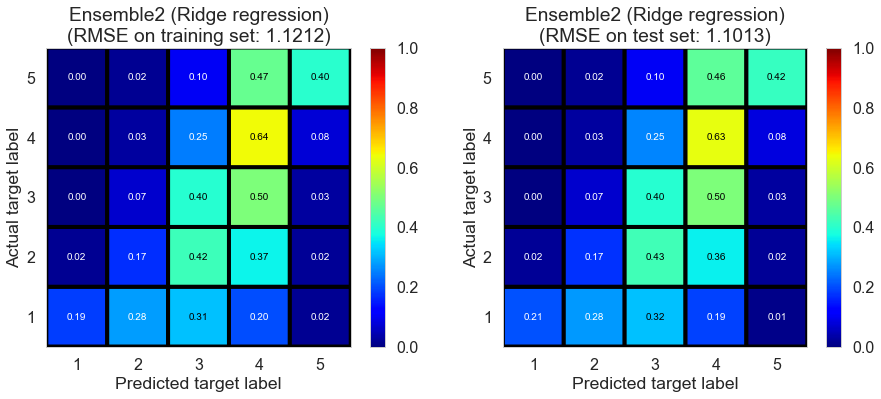

### Ensemble2 (random forest)

Fitting time: 16.1289 s.  
            RMSE on training set: 1.1063.  
            RMSE on test set: 1.1084.  
            $R^2$ on training set: 0.4088.   
            $R^2$ on test set: 0.4064.  
            Classification accuracy on training set: 0.3947.  
            Classification accuracy on test set: 0.3943.
            

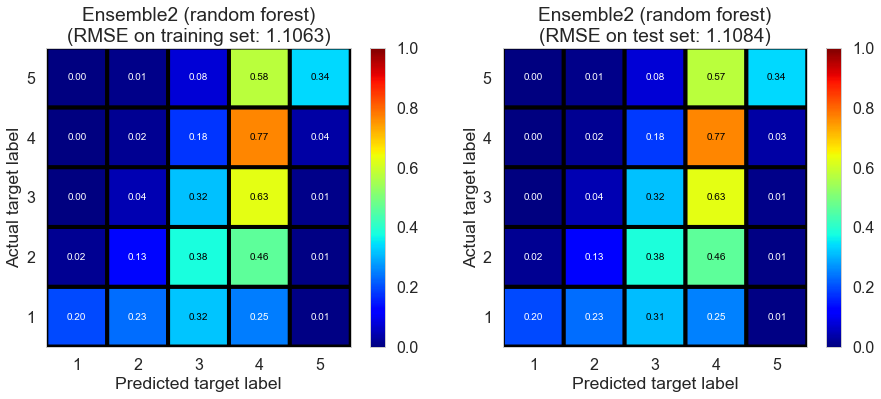


Full...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.7803.  
            RMSE on test set: 1.2557.  
            $R^2$ on training set: 0.6990.   
            $R^2$ on test set: 0.2214.  
            Classification accuracy on training set: 0.4827.  
            Classification accuracy on test set: 0.2926.
            

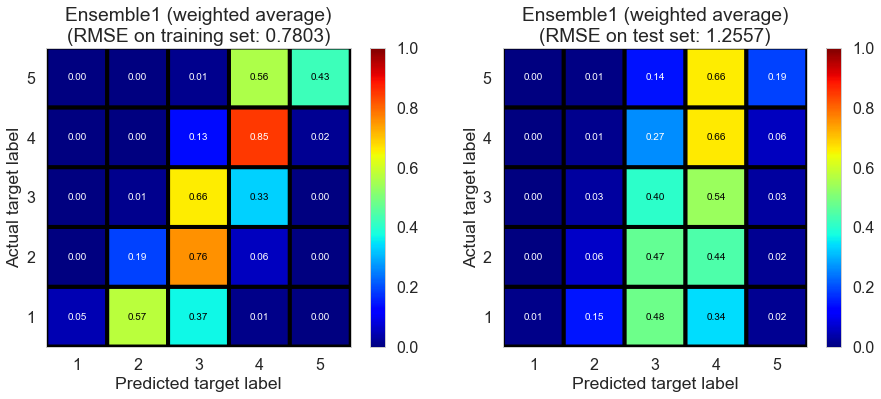

### Ensemble1 (Ridge regression)

Fitting time: 0.4240 s.  
            RMSE on training set: 1.0004.  
            RMSE on test set: 1.2523.  
            $R^2$ on training set: 0.5051.   
            $R^2$ on test set: 0.2256.  
            Classification accuracy on training set: 0.3732.  
            Classification accuracy on test set: 0.3027.
            

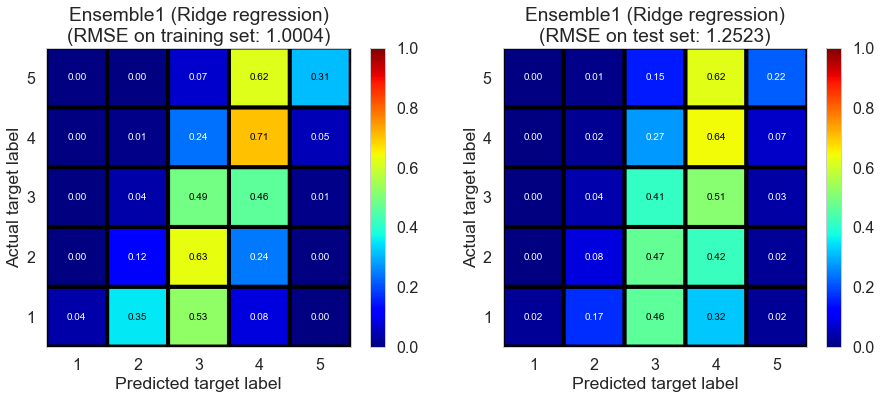

### Ensemble1 (random forest)

Fitting time: 56.5742 s.  
            RMSE on training set: 1.0303.  
            RMSE on test set: 1.2581.  
            $R^2$ on training set: 0.4751.   
            $R^2$ on test set: 0.2184.  
            Classification accuracy on training set: 0.3772.  
            Classification accuracy on test set: 0.3000.
            

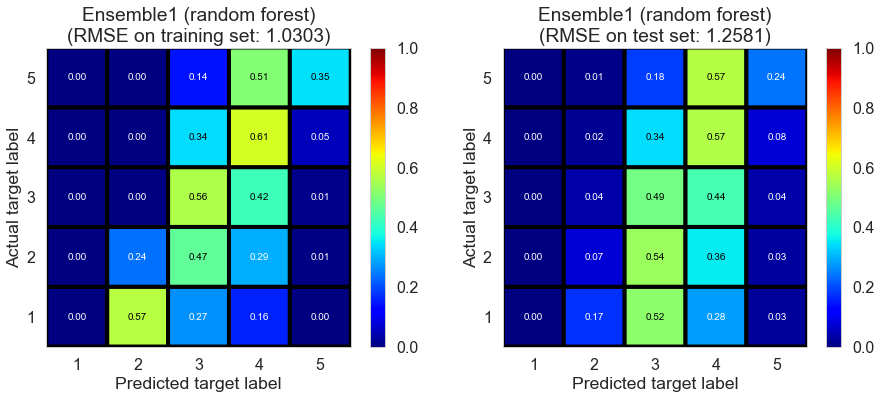

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8688.  
            RMSE on test set: 1.1421.  
            $R^2$ on training set: 0.6268.   
            $R^2$ on test set: 0.3558.  
            Classification accuracy on training set: 0.4470.  
            Classification accuracy on test set: 0.3349.
            

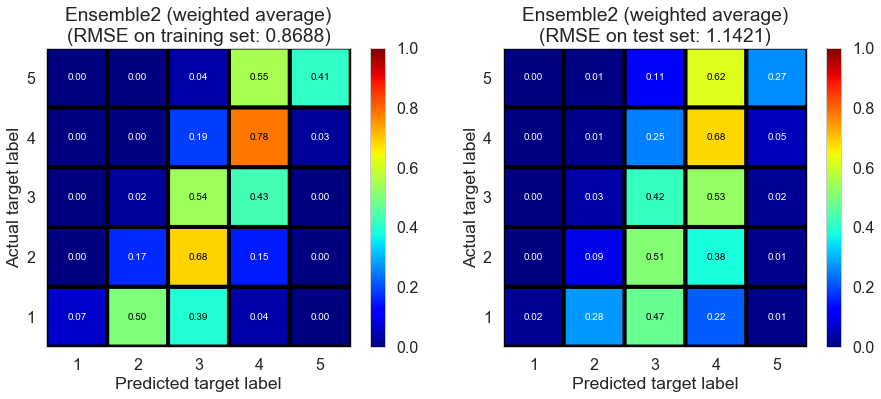

### Ensemble2 (Ridge regression)

Fitting time: 0.5450 s.  
            RMSE on training set: 1.1033.  
            RMSE on test set: 1.0617.  
            $R^2$ on training set: 0.3980.   
            $R^2$ on test set: 0.4434.  
            Classification accuracy on training set: 0.4191.  
            Classification accuracy on test set: 0.4331.
            

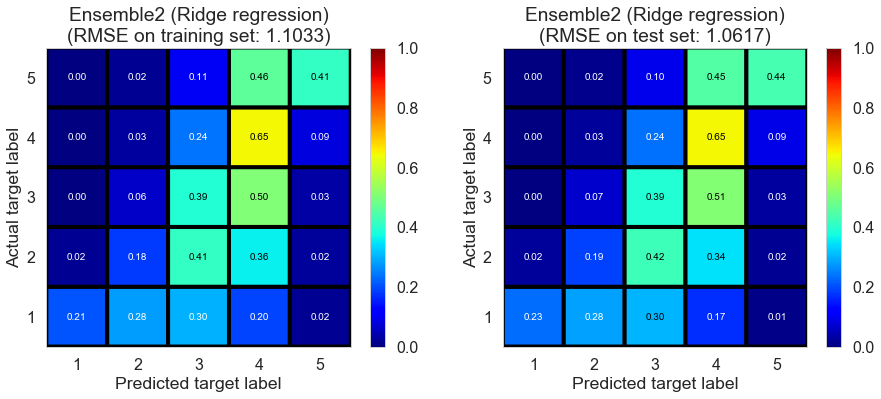

### Ensemble2 (random forest)

Fitting time: 68.1969 s.  
            RMSE on training set: 1.0687.  
            RMSE on test set: 1.0702.  
            $R^2$ on training set: 0.4352.   
            $R^2$ on test set: 0.4344.  
            Classification accuracy on training set: 0.4234.  
            Classification accuracy on test set: 0.4223.
            

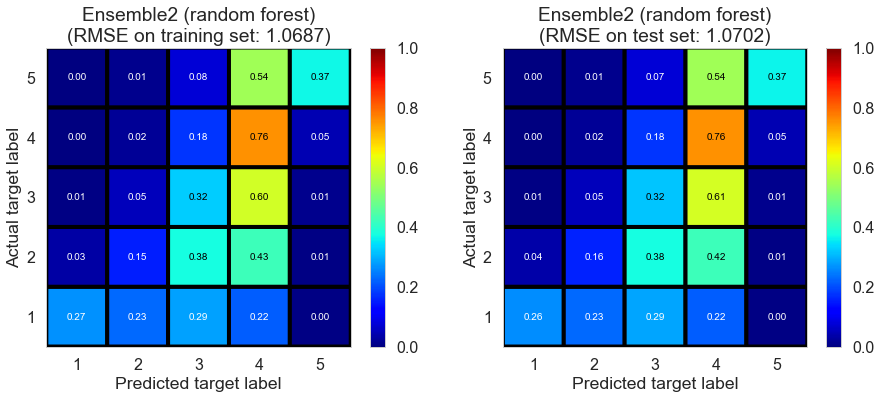


Wall time: 39.9 s


In [8]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    is_successful = IO(data_dir + 'results06/is_successful.pkl').read_pickle()
    datanames = IO(data_dir + 'results06/datanames.pkl').read_pickle()
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    results = IO(data_dir + 'results06/results.pkl').read_pickle()
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

    for i in range(len(is_successful)):
        if is_successful[i]:
            model = IO(datanames[i]).read_pickle()
            show_results(model, model_names[i], None, y_train, None, y_test, results=results[i], show_cv=False)
            del model